In [1]:
import pyomo.environ as pyo
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pyomo.contrib import appsi
from models.mp_controller.mp_controller import MPController
from models.mp_controller.opt_models.energy_community import EC__Residual_Load_MILP_model
from models.mp_controller.opt_models.dhwh import DHW_MILP_model_Temp
from models.mp_controller.opt_models.battery_storage import BES_MILP_model
from models.mp_controller.opt_models.objective import Objective
from models.mp_controller.forcasting import Forcasting

import cProfile

In [ ]:
class RandomForecastingMock():
    def __init__(self, inputs, bounds=(0, 1), set_to_zero=None):
        self.inputs = inputs
        self.bounds = bounds
        if not set_to_zero:
            self.set_to_zero = bounds[0]
        else:
            self.set_to_zero = set_to_zero
        self.n = 1

    def get_forcast(self, time) -> list:
        forecast = self.bounds[0] + np.random.random(self.n) * (self.bounds[1] - self.bounds[0])
        forecast[forecast < self.set_to_zero] = 0
        return forecast.tolist()

    def set_data(self, time):
        pass
    
    def set_forcast_length(self, n):
        self.n = n
             
             
mp_contr = MPController(name='MPC', n_periods=96, delta_t=60*15, 
                        return_forcast=True, 
                        return_future_state=True,
                        return_future_control_output=True)

objective = Objective('objective', objective='self-consumption')
mp_contr.add_model(objective)

milp_ec  = EC__Residual_Load_MILP_model()
mp_contr.add_model(milp_ec)

ec_forcast = RandomForecastingMock([], (-100, 100))
mp_contr.add_forcaster(ec_forcast, milp_ec, 'P_resid_ec')


milp_bes = BES_MILP_model(
    name='bes',
    E_min=0,
    E_max=20_000*3600, # J
    P_max_cha=2000, # W
    P_max_dis=2000, # W
    eta_cha=0.9, # 
    eta_dis=0.9 # 
    )
mp_contr.add_model(milp_bes)


milp_dhwh1 = DHW_MILP_model_Temp(name='dhwh1')
mp_contr.add_model(milp_dhwh1)

dhwh1_forcast = RandomForecastingMock([], (0, 3_000), 10)
mp_contr.add_forcaster(dhwh1_forcast, milp_dhwh1, 'dot_Q_demand')


check = False

mp_contr.solver.update_config.check_for_new_or_removed_constraints = check
mp_contr.solver.update_config.check_for_new_or_removed_vars = check
mp_contr.solver.update_config.update_constraints = check
mp_contr.solver.update_config.update_vars = check

out = {}
l = 1
for t in range(l):
    print(f'{t} / {l}', end='\r')
    inp = {'bes.E_BES_0':float(np.random.random(1)[0]) *1_000, 'dhwh1.T_tes_0': 10 + float(np.random.random(1)[0])*70}
    out[t] = mp_contr.step(t, **inp)
    out[t].update(inp)

2 RangeSet Declarations
    periods : Dimen=1, Size=96, Bounds=(0, 95)
        Key  : Finite : Members
        None :   True :  [0:95]
    timepoints : Dimen=1, Size=97, Bounds=(0, 96)
        Key  : Finite : Members
        None :   True :  [0:96]

1 Param Declarations
    delta_t : Size=1, Index=None, Domain=Any, Default=None, Mutable=False
        Key  : Value
        None :   900

1 Expression Declarations
    sum_expr_P_el : Size=96, Index=periods
        Key : Expression
          0 : objective.P_el[0] + EC.P_el[0] + bes.P_el[0] + dhwh1.P_el[0]
          1 : objective.P_el[1] + EC.P_el[1] + bes.P_el[1] + dhwh1.P_el[1]
          2 : objective.P_el[2] + EC.P_el[2] + bes.P_el[2] + dhwh1.P_el[2]
          3 : objective.P_el[3] + EC.P_el[3] + bes.P_el[3] + dhwh1.P_el[3]
          4 : objective.P_el[4] + EC.P_el[4] + bes.P_el[4] + dhwh1.P_el[4]
          5 : objective.P_el[5] + EC.P_el[5] + bes.P_el[5] + dhwh1.P_el[5]
          6 : objective.P_el[6] + EC.P_el[6] + bes.P_el[6] + dhwh1.P

In [ ]:
df = pd.DataFrame.from_dict(out, orient='index')

In [ ]:
df

,bes.P_el,dhwh1.on,EC.forecaste.P_resid_ec,dhwh1.forecaste.dot_Q_demand,bes.P_el_future,dhwh1.on_future,bes.E_future,dhwh1.T_tes_future,bes.E_BES_0,dhwh1.T_tes_0
0,0.0,1.0,"[-35.03728577565073, 24.080416982541422, 85.12...","[707.6311789564317, 999.0782716316739, 2606.77...","[0.0, -0.8213729656393401, 0.0, 0.0, 0.0, 0.0,...","[1.0, 0.0, 0.0, 0.0, 1.0, 1.0, 0.0, 0.0, 0.0, ...","[821.3729656393401, 821.3729656393401, 0.0, 0....","[42.14056077820501, 43.52524165789454, 42.4548...",821.372966,42.140561


In [ ]:
# TODO: rewrite controller to return future state and future control output

Text(0, 0.5, 'ON')

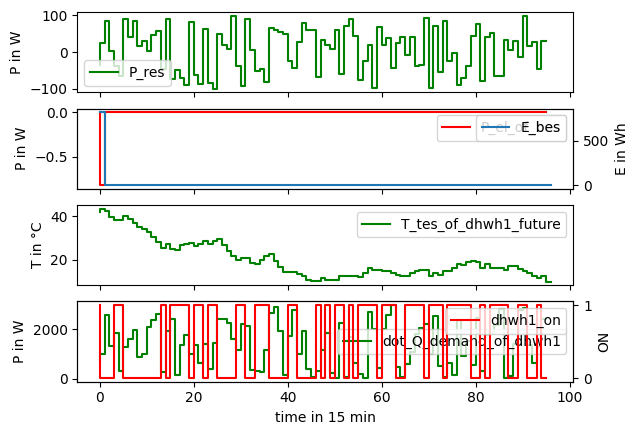

In [ ]:
fig, axs = plt.subplots(4, 1, sharex=True)  # , sharey=True)
t = 0

axs[0].plot(df.loc[t, 'EC.forecaste.P_resid_ec'], label='P_res', drawstyle='steps', color='green')
axs[0].legend()
axs[0].set_ylabel('P in W')

axs[1].plot(df.loc[t, 'bes.P_el_future'], label='P_el_of_bes', drawstyle='steps', color='red')
axs[1].legend()
axs[1].set_ylabel('P in W')
twinx_1 = axs[1].twinx()
twinx_1.plot(df.loc[t, 'bes.E_future'], label='E_bes', drawstyle='steps')
twinx_1.legend()
twinx_1.set_ylabel('E in Wh')


axs[2].plot(df.loc[t, 'dhwh1.T_tes_future'], label='T_tes_of_dhwh1_future', drawstyle='steps', color='green')
axs[2].legend()
axs[2].set_ylabel('T in °C')

axs[3].plot(df.loc[t, 'dhwh1.forecaste.dot_Q_demand'], label='dot_Q_demand_of_dhwh1', drawstyle='steps', color='green')
axs[3].legend()
axs[3].set_ylabel('P in W')
axs[3].set_xlabel('time in 15 min')

twinx_2 = axs[3].twinx()
twinx_2.plot(df.loc[t, 'dhwh1.on_future'], label='dhwh1_on', drawstyle='steps', color='red')
twinx_2.legend()
twinx_2.set_ylabel('ON')

In [ ]:
nt = namedtuple('Inputs', ['x', 'y'])

NameError: name 'namedtuple' is not defined

In [ ]:
from typing import NamedTuple

class Inputs(NamedTuple):
    def __init__():
        self.add



In [ ]:
a = nt(1, 2)

In [ ]:
class Model():
    def __init__(self):
        self.name

    def set_inputs(self, *input_names):
        nt = namedtuple('Inputs', input_names)
        return nt(*[i + '_of_'+ self.name for i in input_names])
    
    def set_inputs(self, *input_names):
        return SimpleNamespace(**{i: i + '_of_'+ self.name for i in input_names})

In [ ]:
class Inputs():
    def __init__(self, *inputs):
        for inp in inputs:
            self.__setattr__(inp, inp)

In [ ]:
class DynamicAttributesMeta(type):
    def __new__(cls, name, bases, dct):
        dct["_dynamic_attributes"] = set()  # Track dynamic attributes
        return super().__new__(cls, name, bases, dct)


class Inputs(metaclass=DynamicAttributesMeta):
    def __init__(self, *inputs):
        for inp in inputs:
            setattr(self, inp, inp)
            self.__class__._dynamic_attributes.add(inp)

    def __getattr__(self, name):
        if name in self.__class__._dynamic_attributes:
            return name
        raise AttributeError(f"'{self.__class__.__name__}' object has no attribute '{name}'")



obj = Inputs("x", "y", "z")


In [ ]:
from functools import partial
from collections import namedtuple

inputs = partial(namedtuple, 'Inputs') 

def inputs(*inputs):
    nt = namedtuple('Inputs', (inputs))
    return nt(*inputs)


In [ ]:
inp = inputs('A', 'B', 'C')

In [ ]:
inp.A

'A'

In [ ]:
__qualname__

In [ ]:
from typing import NamedTuple
class Input(NamedTuple):
    pass

In [ ]:

class MyModel():
    inputs = namedtuple('Input', ('A', 'B'))

    def __init__(self):
        self.name = 'name'

In [ ]:
m = MyModel()


In [ ]:
inputs = namedtuple('Input', ('A', 'B'))

In [ ]:
import pyomo.environ as pyo
from typing import Protocol, runtime_checkable

@runtime_checkable
class MILPModelProto(Protocol):
    def __init__(self, name:str):
        self.state_inputs     = [] # inputs to the state, needs to be a Parameter of the pyo.Block
        self.forcast_inputs   = [] # inputs for forecast values, needs to be a Parameter of the pyo.Block with index model.periods
        self.controll_outputs = [] # outputs to the controller, needs to be a Variable of the pyo.Block with index model.periods
        self.shares           = [] # connection to other variables (following egoistic sign logic, + is consumption, -is feedin) needs to be a pyo.Variable with index model.periods
        self.name             =   'a'

    def pyo_block_rule(self, block:pyo.Block) -> None:
        model = block.model()


class ComponentMock():
    def __init__(self):
        pass
        # self.state_inputs     = [] # inputs to the state, needs to be a Parameter of the pyo.Block
        # self.forcast_inputs   = [] # inputs for forecast values, needs to be a Parameter of the pyo.Block with index model.periods
        # self.controll_outputs = [] # outputs to the controller, needs to be a Variable of the pyo.Block with index model.periods
        # self.shares           = [] # connection to other variables (following egoistic sign logic, + is consumption, -is feedin) needs to be a pyo.Variable with index model.periods
        # self.name             =   'a'
        
    def pyo_block_rule(self, block):
        block.P_el = pyo.Var(block.model().periods)

c = ComponentMock()

isinstance(ComponentMock, MILPModelProto)

True

In [ ]:
import pandas as pd

reccords = [
(pd.to_datetime("2020-01-01 12:00"), 1),
(pd.to_datetime("2020-01-01 13:00"), 2),
(pd.to_datetime("2020-01-01 14:00"), 3)
]

pd.DataFrame.from_records(reccords, columns=['index', 'sm'], index='index').squeeze()

index
2020-01-01 12:00:00    1
2020-01-01 13:00:00    2
2020-01-01 14:00:00    3
Name: sm, dtype: int64